In [ ]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from PIL import Image

In [ ]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [ ]:
link = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSZncVFOd8m_qIp3LN7KRH17tuhDyOv0Pf6uaEzpQjTY6Ud8iPSVJEJN2-rq_p7q5Je_yVOrrgOTseD/pub?gid=822875922&single=true&output=csv"

In [ ]:
df_f = pd.read_csv(link, sep=";", decimal='.')
df_f = df_f.rename(columns ={'Tiempo (ms)':"Tiempo[ms]", 'AngleToVertical 1,':'Angulo'})
df_f.Angulo = df_f.Angulo.str.replace(',','.').astype(float)
df_f['Angulo_rad']=np.deg2rad(df_f.Angulo)

Solución analítica del pendulo amortiguado:

$θ(t)=e^{−βt}(Acos(ω_{∗}t)+Bsin(ω_{∗}t))$.

Donde: $ω∗=\sqrt{(w^2-β^2)}$

Para el caso sobreamortiguado $β > w$, la solución es:

$θ(t)=c1e^{α_{+}t}+c2e^{α_{−}t}$

In [ ]:
def pendulum_damped(beta, w0, t):
    """
    Defines the analytical solution to the damped pendulum problem for small angles.

    Parameters:
    beta (float): Damping coefficient.
    w0 (float): Natural frequency (sqrt(g/L)).
    t (torch.Tensor): Time values.

    Returns:
    torch.Tensor: Angular displacement over time.
    """
    assert beta < w0, "The damping coefficient must be less than the natural frequency for underdamping."

    # Calculate the damped frequency
    wd = np.sqrt(w0**2 - beta**2)

    # Phase angle
    phi = np.arctan(-beta / wd)

    # Amplitude factor
    A = 1 / (2 * np.cos(phi))

    # Calculate the components
    cos_component = torch.cos(phi + wd * t)
    exp_component = torch.exp(-beta * t)

    # Angular displacement over time
    theta = exp_component * 2 * A * cos_component

    return theta

# Example usage (assuming g = 9.81 m/s^2 and L = 1 m)
g = 9.81
L = 1.0
w0 = np.sqrt(g / L)
beta = 0.1
t = torch.linspace(0, 12, 300)

theta = pendulum_damped(beta, w0, t)
#print(theta)

torch.Size([146, 1]) torch.Size([146, 1])
torch.Size([34, 1]) torch.Size([34, 1]) torch.float32


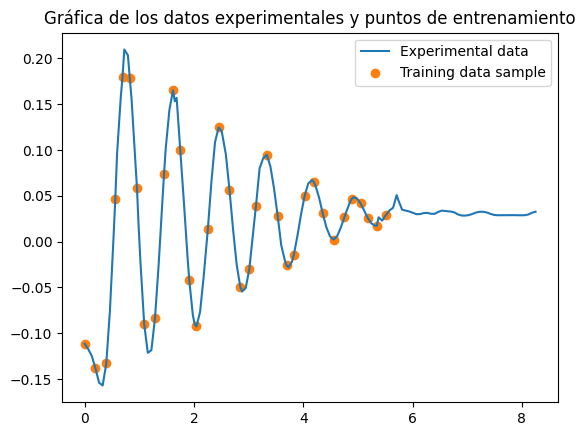

In [ ]:
#d, w0 = 2, 20

# get the analytical solution over the full domain
#t = torch.linspace(0,12,146).view(-1,1)
t = torch.tensor(df_f['Tiempo[ms]']/1000,dtype=torch.float32).view(-1,1)
y = torch.tensor(df_f['Angulo_rad'],dtype=torch.float32).view(-1,1)
#y = pendulum_damped(beta, w0, t).view(-1,1)
print(t.shape, y.shape)

# slice out a small number of points from the LHS of the domain
t_data = t[0:100:3]
y_data = y[0:100:3]
print(t_data.shape, y_data.shape,t.dtype)

plt.figure()
plt.plot(t, y, label="Experimental data")
#plt.plot(df_f['Tiempo[ms]']/1000,df_f['Angulo_rad'], label='Experimental data')
plt.scatter(t_data, y_data, color="tab:orange", label="Training data sample")
plt.title('Gráfica de los datos experimentales y puntos de entrenamiento')
plt.legend()
plt.savefig('pendulo.jpg')
plt.show()

In [ ]:
class FullyConnected(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.ReLU):
        super().__init__()
        layers = []

        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())

        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )

    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)

        return outpt

In [ ]:
def plot_result(x,y,x_data,y_data,yh, i, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

In [ ]:
# Función de entrenamiento modificada para el péndulo amortiguado
def train_pendulum(x_data,y_data):

    x_physics = torch.linspace(0, 4, 34).view(-1, 1).requires_grad_(True)  # ubicaciones de muestra sobre el dominio del problema
    # test data

    gamma, g, l = 0.1, 9.81, 0.4
    k = g / l

    # Inicializar la red neuronal
    model = FullyConnected([1, 32, 32, 32, 1], activation=nn.Tanh)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    files= []
    epochs = 20000
    losses = dict(dataloss=[], physicsloss=[])

    for i in range(epochs):
        optimizer.zero_grad()

        # Calcular la "data loss"
        yh = model(x_data) #training prediccion
        dataloss = torch.mean((yh - y_data) ** 2)  # usar error cuadrático medio

        # Calcular la "physics loss"
        yhp = model(x_data.requires_grad_(True)) #X_physics data test
        dx = torch.autograd.grad(yhp, x_data.requires_grad_(True), torch.ones_like(yhp), create_graph=True)[0]  # calcula dy/dx
        dx2 = torch.autograd.grad(dx, x_data.requires_grad_(True), torch.ones_like(dx), create_graph=True)[0]  # calcula d^2y/dx^2
        physics = dx2 + gamma * dx + k * torch.sin(yhp)  # residual de la ecuación diferencial del péndulo amortiguado
        physicsloss = (1e-6) * torch.mean(physics ** 2)
        #physicsloss =  torch.mean(physics ** 2)

        # Propagar la pérdida conjunta
        loss = dataloss + physicsloss  # sumar las dos pérdidas
        loss.backward()
        optimizer.step()
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())


        if (i+1) % (epochs//5) == 0:

            yh = model(t).detach()  # t: experimental data
            xp = x_physics.detach()

            plot_result(t,y,x_data.detach(),y_data,yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
#            xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
            plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, -(gamma * dx + k * torch.sin(yhp)).detach().numpy(), label="physics law")
            plt.legend()
            figs.append(fig)
#            print(dx)
#           print(dx2, '\n',  mu*dx + k*yhp)
            print("data physics loss", dataloss, physicsloss)
#            file = "plots/pinn_%.8i.png"%(i+1)
#            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#            files.append(file)

#            if (i+1) % 200 == 0: plt.show()
#            else: plt.close("all")
    return losses

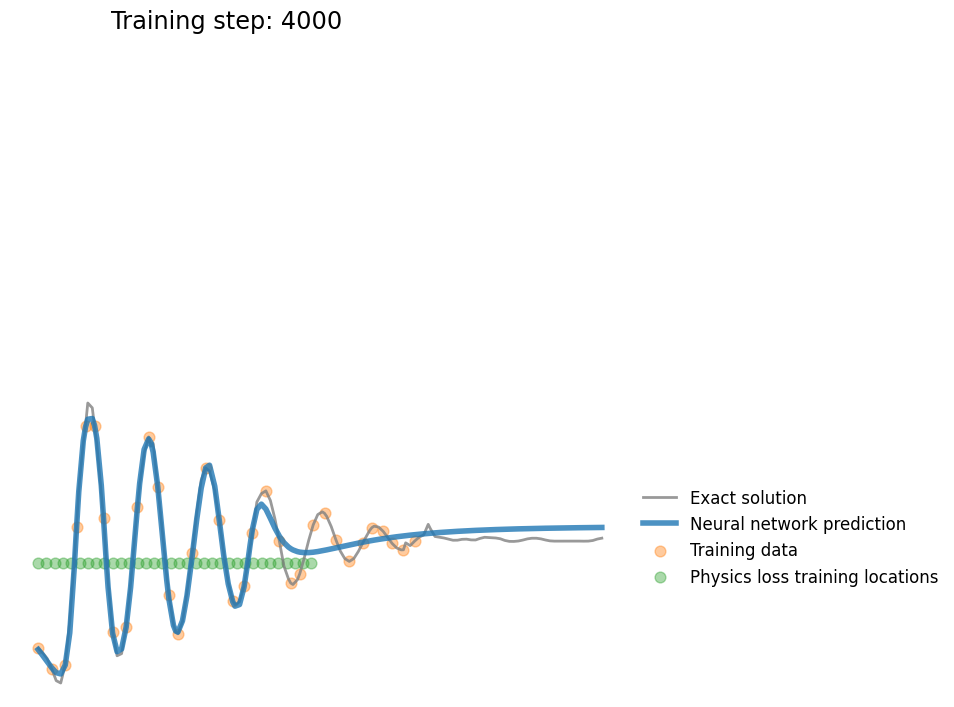

data physics loss tensor(0.0003, grad_fn=<MeanBackward0>) tensor(5.5900e-06, grad_fn=<MulBackward0>)


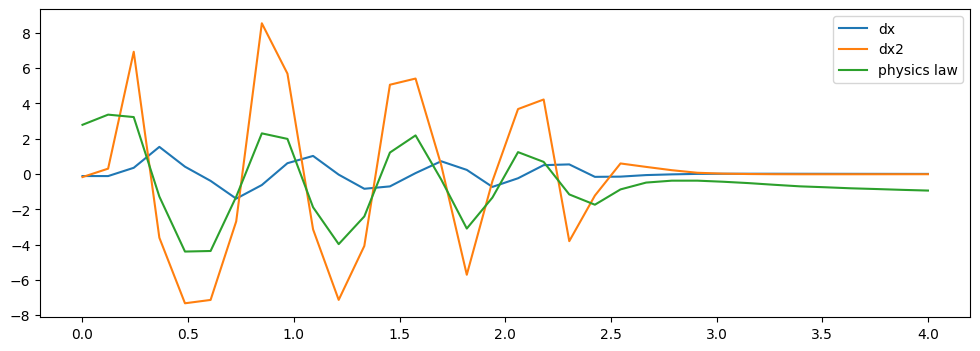

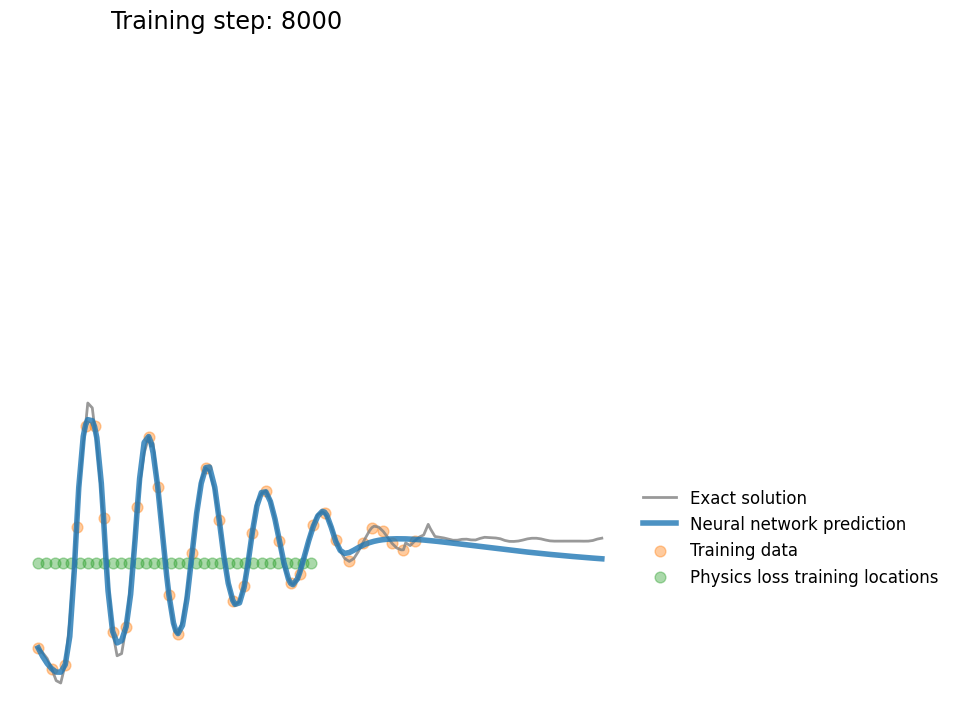

data physics loss tensor(2.6196e-05, grad_fn=<MeanBackward0>) tensor(5.0598e-06, grad_fn=<MulBackward0>)


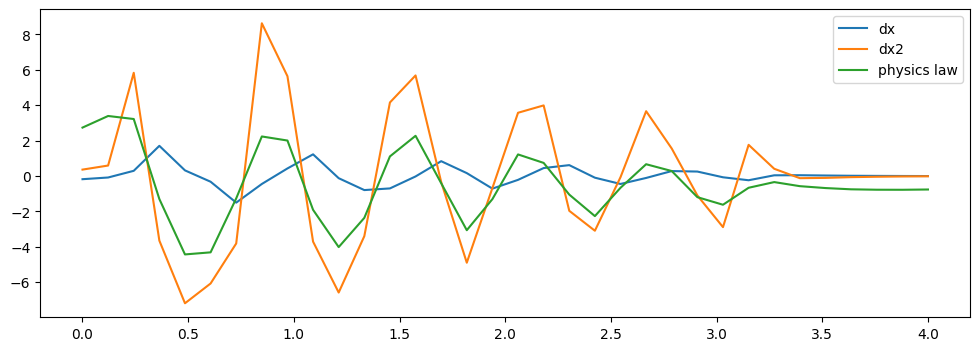

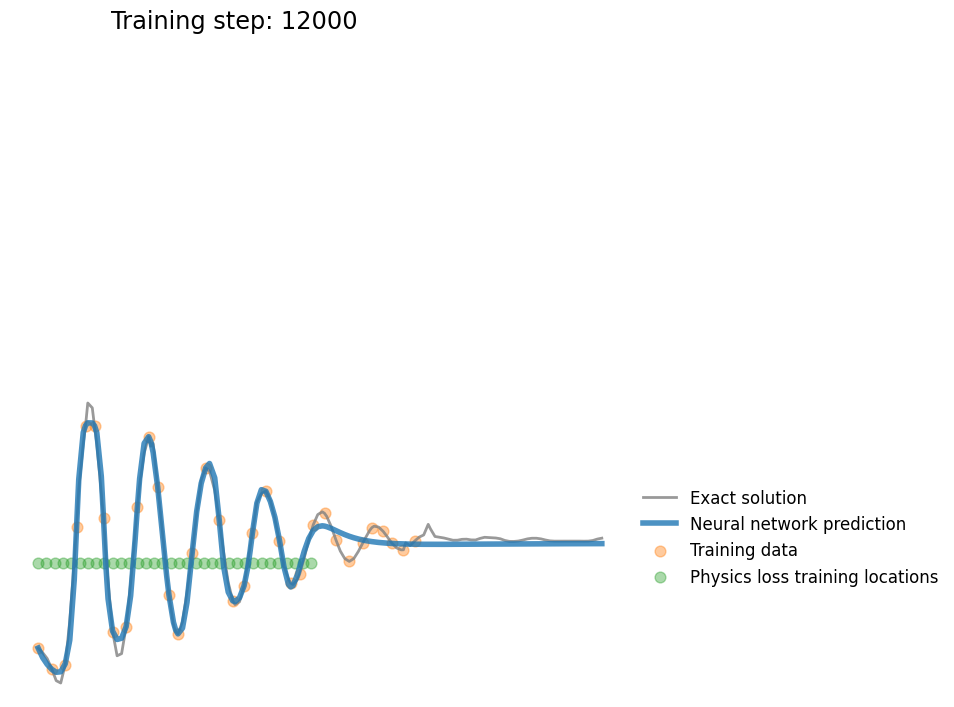

data physics loss tensor(6.8475e-05, grad_fn=<MeanBackward0>) tensor(3.4726e-06, grad_fn=<MulBackward0>)


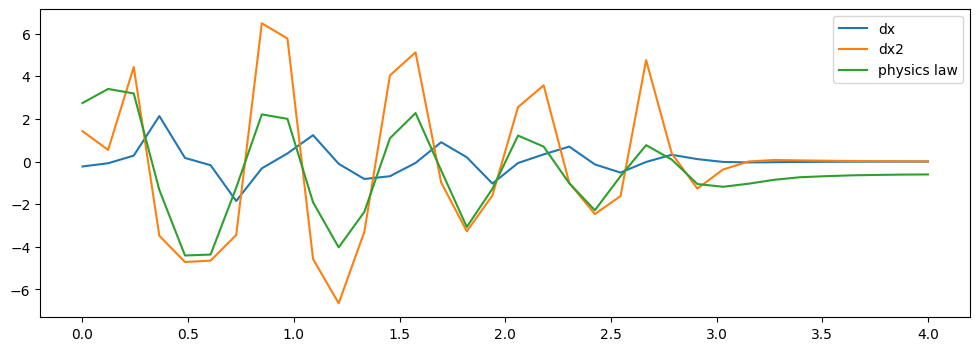

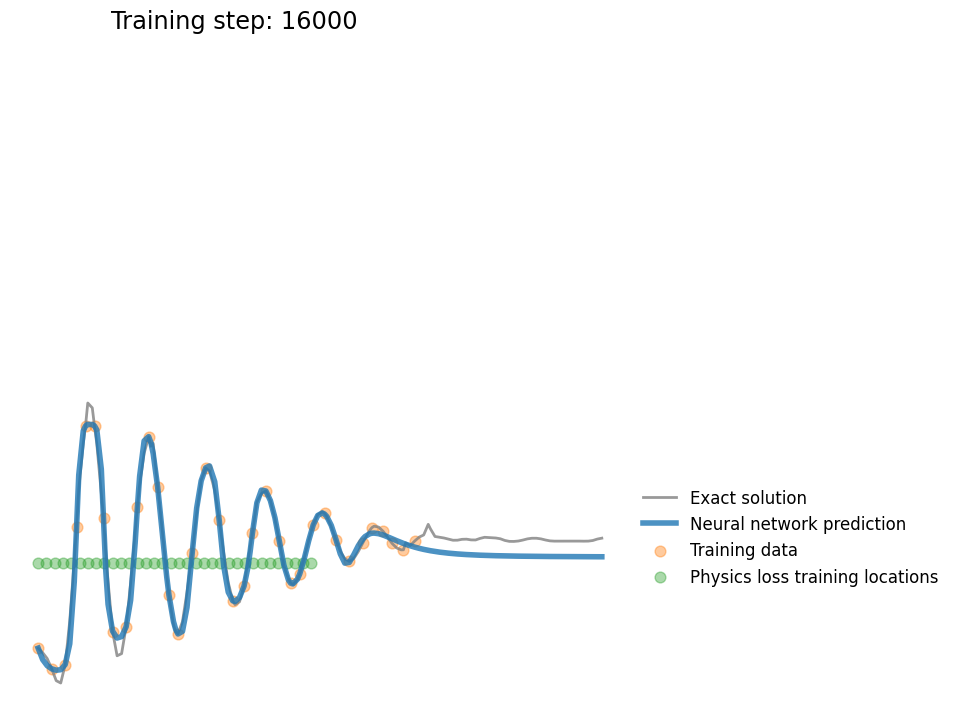

data physics loss tensor(8.3567e-06, grad_fn=<MeanBackward0>) tensor(2.6995e-06, grad_fn=<MulBackward0>)


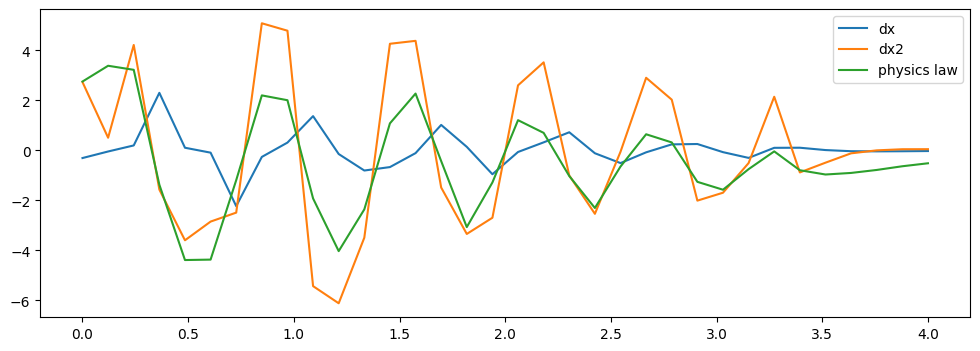

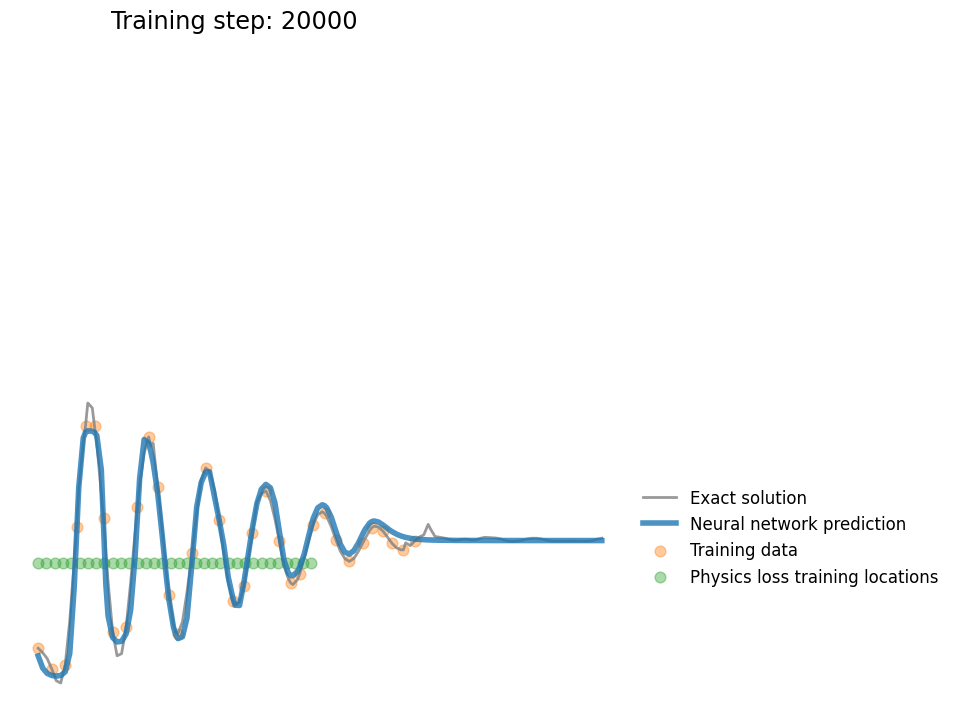

data physics loss tensor(4.9363e-05, grad_fn=<MeanBackward0>) tensor(1.9963e-06, grad_fn=<MulBackward0>)


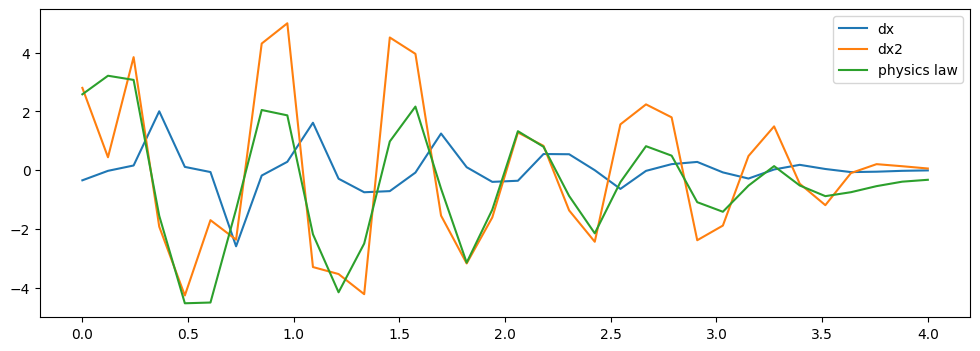

In [ ]:
figs=[]
losses = train_pendulum(t_data,y_data)

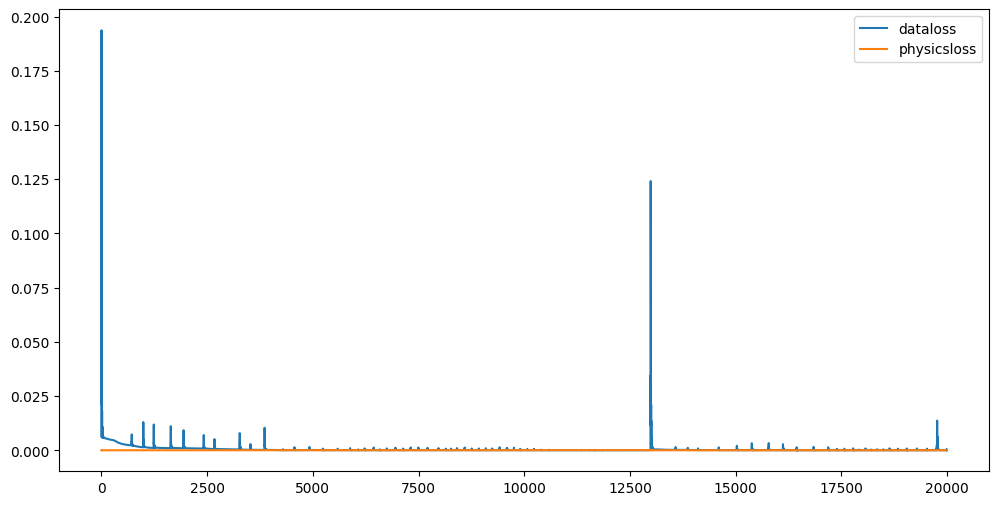

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(losses["dataloss"])), losses["dataloss"], label="dataloss")
plt.plot(range(len(losses["physicsloss"])), losses["physicsloss"], label="physicsloss")
#plt.ylim(0.0, 0.002)
plt.legend()

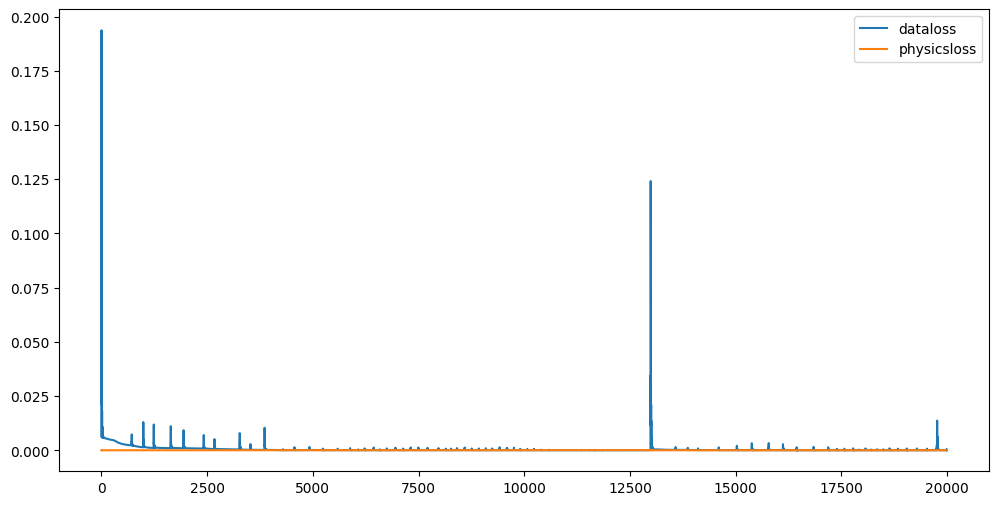

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(losses["dataloss"])), losses["dataloss"], label="dataloss")
plt.plot(range(len(losses["physicsloss"])), losses["physicsloss"], label="physicsloss")
#plt.ylim(0.0, 0.002)
plt.legend()

In [ ]:
model = FullyConnected([1, 32, 32, 32, 1], activation=nn.Tanh)
t_test = np.linspace(0,8,34)
t_test = torch.tensor(t_test, dtype=torch.float32)
t_test = t_test.view(-1, 1)
y_test = model(t_test)
val_error = mean_squared_error(y_data, y_test.detach().numpy())
val_error

0.014043458

<ipython-input-14-3d003ffbc531>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_data = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)  # Suponiendo que t_data sea numpy array
<ipython-input-14-3d003ffbc531>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)


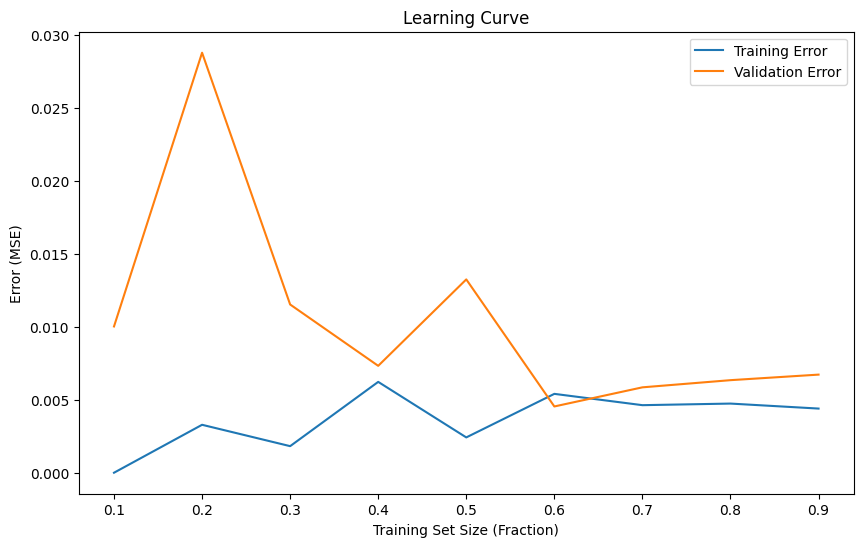

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que tienes un modelo de red neuronal definido como 'model'
# y un conjunto de datos de entrada t_data, con etiquetas y_data correspondientes
# Aquí se asume que ya has definido el modelo previamente.

# Convertir los datos de entrada y etiquetas a tensores
t_data = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)  # Suponiendo que t_data sea numpy array
y_data = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)

# Lista para almacenar los errores
train_errors = []
val_errors = []

# Fracciones del conjunto de entrenamiento que usarás (10% al 90% de los datos)
train_sizes = np.linspace(0.1, 0.9, 9)  # Cambié el rango de 0.1 a 0.9

# Bucle para iterar sobre las diferentes fracciones del conjunto de entrenamiento
for frac in train_sizes:
    # Dividir los datos en entrenamiento y validación
    t_train, t_val, y_train, y_val = train_test_split(t_data, y_data, train_size=frac)#, random_state=42)

    # Entrenar el modelo en este subconjunto
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()

    # Entrenamiento básico (ajusta el número de épocas según tu modelo)
    model.train()
    for epoch in range(100):  # Ajusta el número de épocas si es necesario
        optimizer.zero_grad()
        y_train_pred = model(t_train)
        loss = criterion(y_train_pred, y_train)
        loss.backward()
        optimizer.step()

    # Evaluar el error de entrenamiento
    y_train_pred = model(t_train)
    train_error = mean_squared_error(y_train.detach().numpy(), y_train_pred.detach().numpy())
    train_errors.append(train_error)

    # Evaluar el error de validación
    model.eval()  # Cambiar el modelo a modo de evaluación
    with torch.no_grad():  # Deshabilitar el cálculo de gradientes
        y_val_pred = model(t_val)
        val_error = mean_squared_error(y_val.detach().numpy(), y_val_pred.detach().numpy())
    val_errors.append(val_error)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training Error')
plt.plot(train_sizes, val_errors, label='Validation Error')
plt.xlabel('Training Set Size (Fraction)')
plt.ylabel('Error (MSE)')
plt.title('Learning Curve')
plt.legend()
plt.show()
